In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from kmodes.kprototypes import KPrototypes
from sklearn.mixture import GaussianMixture

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#!cd 'gdrive/MyDrive/Colab Notebooks/MSFeCare'

In [4]:
data_dir = '/Users/abdulkadirgokce/Documents/MSFeCare/MSF-eCARE-filedrop'

!ls $data_dir

clean_data.csv                          metadata_patient.json
cluster_points.csv                      metadata_patient_pred.json
clustered_data.csv                      ml-dataset-datadictionary_20211001.xlsx
clustering_model.pkl                    model_kp.pkl
datadictionary-workinprogress.xlsx      patient_data.csv
full-310k - Copy xl.xlsx                patient_pred_data.csv
full-310k - Copy.csv                    processed_data.csv
gps_coordinates.json                    ~$full-310k - Copy xl.xlsx
metadata.json


In [5]:
filename = 'patient_data.csv'
file_dir = os.path.join(data_dir, filename)
df = pd.read_csv(file_dir)
df

,country,hf_town,latitude,longitude,week,month,year,datetime,a_age,neuro_any,...,lab_malaria_pos,mouth_trush,s_oedema,s_pallor,s_drepano,s_throat,s_mouthpb,s_joint,sam_u6add_ocp,wfa_less_than_neg3sd
0,RCA,Batangafo,7.303983,18.291091,7,2,2017,2017-02-15 12:11:47,-0.222066,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,RCA,Batangafo,7.303983,18.291091,1,1,2017,2017-01-05 12:39:43,-0.635496,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,RCA,Kambakota,7.157017,17.872181,33,8,2017,2017-08-16 10:05:44,-0.635496,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,RCA,Batangafo,7.303983,18.291091,17,4,2017,2017-04-28 19:19:26,-0.635496,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,RCA,Batangafo,7.303983,18.291091,48,12,2016,2016-12-02 10:22:03,-1.324546,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310284,RCA,Kabo,7.692080,18.624342,11,3,2020,2020-03-12 09:55:48,1.087129,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310285,RCA,Kabo,7.692080,18.624342,2,1,2020,2020-01-08 08:26:21,-1.117831,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310286,RCA,Kabo,7.692080,18.624342,14,4,2020,2020-04-04 10:06:07,0.329174,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310287,RCA,Kabo,7.692080,18.624342,29,7,2020,2020-07-16 14:42:21,-0.290971,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310289 entries, 0 to 310288
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   country               310289 non-null  object 
 1   hf_town               310289 non-null  object 
 2   latitude              310289 non-null  float64
 3   longitude             310289 non-null  float64
 4   week                  310289 non-null  int64  
 5   month                 310289 non-null  int64  
 6   year                  310289 non-null  int64  
 7   datetime              310289 non-null  object 
 8   a_age                 310289 non-null  float64
 9   neuro_any             310289 non-null  float64
 10  muac_low              310289 non-null  float64
 11  s_measles             310289 non-null  float64
 12  nonspecific           310289 non-null  float64
 13  resp_any              310289 non-null  float64
 14  abdo_any              310289 non-null  float64
 15  

In [7]:
with open(os.path.join(data_dir, 'metadata_patient.json'), 'r') as file:
    metadata = json.load(file)
    
categorical_feature_indices = [df.columns.get_loc(c) for c in metadata['categorical_features']]

In [8]:
features_for_clustering = metadata['numerical_features'] + metadata['categorical_features']
clustering_data = df[features_for_clustering].copy()
categorical_feature_indices = [clustering_data.columns.get_loc(c) for c in metadata['categorical_features']]

clustering_data

,a_age,neuro_any,muac_low,s_measles,nonspecific,resp_any,abdo_any,ear_any,eye_sympt,skin_any,...,lab_malaria_pos,mouth_trush,s_oedema,s_pallor,s_drepano,s_throat,s_mouthpb,s_joint,sam_u6add_ocp,wfa_less_than_neg3sd
0,-0.222066,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.635496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.635496,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.635496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.324546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310284,1.087129,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310285,-1.117831,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310286,0.329174,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310287,-0.290971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## K-Prototypes

In [23]:
# KPrototypes initialization
kp = KPrototypes(n_clusters=8, init='Huang', n_init=1, verbose=1)

In [24]:
clustering_alg = 'kp'
assignments = kp.fit_predict(clustering_data, categorical=categorical_feature_indices)
cluster_points = kp.cluster_centroids_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 115177, ncost: 161249.8799941643
Run: 1, iteration: 2/100, moves: 48179, ncost: 158421.12870531113
Run: 1, iteration: 3/100, moves: 5137, ncost: 158323.84111631537
Run: 1, iteration: 4/100, moves: 614, ncost: 158319.21654313756
Run: 1, iteration: 5/100, moves: 33, ncost: 158319.20596037235
Run: 1, iteration: 6/100, moves: 0, ncost: 158319.20596037235


In [126]:
with open(os.path.join(data_dir, 'model_kp.pkl'), 'wb') as file:
    pickle.dump(kp, file)

## Gaussian Mixture Models

In [16]:
# Gaussian Mixture Model initialization
gmm = GaussianMixture(n_components=8, covariance_type='full', n_init=1, max_iter=100, random_state=0)

In [17]:
clustering_alg = 'gmm'
assignments = gmm.fit_predict(clustering_data)
cluster_points = gmm.means_

In [ ]:
with open(os.path.join(data_dir, 'model_gmm.pkl'), 'wb') as file:
    pickle.dump(gmm, file)

## Save outputs

In [22]:
np.unique(assignments, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint16),
 array([32489, 30762, 21598, 36629, 73356, 18656, 48430, 48369]))

In [12]:
# Put cluster points into a DataFrame
cluster_points = pd.DataFrame(cluster_points, columns=features_for_clustering)

In [13]:
#Unnormalize numerical features
numerical_data_mean = pd.Series(metadata['normalization_stats']['numerical_data_mean'])
numerical_data_std = pd.Series(metadata['normalization_stats']['numerical_data_std'])

cluster_points[metadata['numerical_features']] = cluster_points[metadata['numerical_features']]*numerical_data_std
cluster_points[metadata['numerical_features']] += numerical_data_mean



In [14]:
threshold = 0.1

if clustering_alg == 'gmm':
    categorical_features = metadata['categorical_features']
    cluster_points[categorical_features] = (cluster_points[categorical_features]>threshold).astype(int)

In [15]:
# Drop features consisting only of 0's
cluster_points = cluster_points.drop(cluster_points.columns[cluster_points.sum(axis='rows')==0], axis='columns')
cluster_points

,a_age,resp_any,abdo_any
0,28.825623,0.0,0.0
1,10.318631,1.0,1.0
2,10.639971,0.0,0.0
3,50.728310,0.0,0.0
4,11.167507,0.0,1.0
5,35.964257,1.0,0.0
6,8.746894,1.0,0.0
7,22.747083,1.0,0.0


In [130]:
cluster_points.to_csv(os.path.join(data_dir, 'cluster_points.csv'), index=False)

In [127]:
# Create DataFrame containing spatiotemporal clustering information
n_clusters = 10

st_clustering_features = [
    'datetime',
    'country', 
    'hf_town', 
    'latitude', 
    'longitude'
]


spatiotemporal_clustering = df[st_clustering_features].copy()
spatiotemporal_clustering['assigned_cluster'] = assignments

spatiotemporal_clustering

,datetime,country,hf_town,latitude,longitude,assigned_cluster
0,2017-02-15 12:11:47,RCA,Batangafo,7.303983,18.291091,6
1,2017-01-05 12:39:43,RCA,Batangafo,7.303983,18.291091,5
2,2017-08-16 10:05:44,RCA,Kambakota,7.157017,17.872181,3
3,2017-04-28 19:19:26,RCA,Batangafo,7.303983,18.291091,5
4,2016-12-02 10:22:03,RCA,Batangafo,7.303983,18.291091,0
...,...,...,...,...,...,...
310284,2020-03-12 09:55:48,RCA,Kabo,7.692080,18.624342,2
310285,2020-01-08 08:26:21,RCA,Kabo,7.692080,18.624342,7
310286,2020-04-04 10:06:07,RCA,Kabo,7.692080,18.624342,2
310287,2020-07-16 14:42:21,RCA,Kabo,7.692080,18.624342,5


In [128]:
spatiotemporal_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310289 entries, 0 to 310288
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datetime          310289 non-null  object 
 1   country           310289 non-null  object 
 2   hf_town           310289 non-null  object 
 3   latitude          310289 non-null  float64
 4   longitude         310289 non-null  float64
 5   assigned_cluster  310289 non-null  uint16 
dtypes: float64(2), object(3), uint16(1)
memory usage: 12.4+ MB


In [129]:
spatiotemporal_clustering.to_csv(os.path.join(data_dir, 'clustered_data.csv'), index=False)

## Optimal Number of Clusters

In [37]:
from tqdm.notebook import tqdm

Plot loss of K-Prototypes as a function of number of clusters

In [71]:
kp_loss = []

n_iters = 10
for n_clusters in tqdm(range(2,12)):
    
    loss = 0
    for _ in tqdm(range(n_iters), leave=False):
        kp = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=1, verbose=1)
        kp.fit(clustering_data, categorical=categorical_feature_indices)
        loss += kp.cost_
        
    kp_loss.append(loss/n_iters)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 36124, ncost: 303461.1367664892
Run: 1, iteration: 2/100, moves: 25054, ncost: 297733.82098015427
Run: 1, iteration: 3/100, moves: 1880, ncost: 297699.1795463832
Run: 1, iteration: 4/100, moves: 274, ncost: 297698.44021933246
Run: 1, iteration: 5/100, moves: 0, ncost: 297698.44021933246
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 44390, ncost: 303895.1250508046
Run: 1, iteration: 2/100, moves: 25981, ncost: 297738.67468376295
Run: 1, iteration: 3/100, moves: 2001, ncost: 297699.4171930756
Run: 1, iteration: 4/100, moves: 315, ncost: 297698.44021933334
Run: 1, iteration: 5/100, moves: 0, ncost: 297698.44021933334
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 80786, ncost: 305089.0634661
Run: 1, iteration: 2/100, moves: 28160, ncost: 297760.61

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 74697, ncost: 249341.7216637415
Run: 1, iteration: 2/100, moves: 43045, ncost: 237338.67871131882
Run: 1, iteration: 3/100, moves: 6050, ncost: 237025.27390824415
Run: 1, iteration: 4/100, moves: 299, ncost: 237023.6270740245
Run: 1, iteration: 5/100, moves: 0, ncost: 237023.6270740245
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 58331, ncost: 257960.86337077743
Run: 1, iteration: 2/100, moves: 15361, ncost: 255836.4456764506
Run: 1, iteration: 3/100, moves: 365, ncost: 255834.3191755281
Run: 1, iteration: 4/100, moves: 0, ncost: 255834.3191755281
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 68588, ncost: 242197.79513372754
Run: 1, iteration: 2/100, moves: 3743, ncost: 242129.23752862433
Run: 1, iteration: 3/100, moves: 0, ncost: 242129.2375

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 46523, ncost: 225170.77624913142
Run: 1, iteration: 2/100, moves: 7901, ncost: 224890.27789665747
Run: 1, iteration: 3/100, moves: 1247, ncost: 224867.0803500695
Run: 1, iteration: 4/100, moves: 0, ncost: 224867.0803500695
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 72068, ncost: 201526.4709149671
Run: 1, iteration: 2/100, moves: 1034, ncost: 201521.07450268607
Run: 1, iteration: 3/100, moves: 160, ncost: 201520.74784677944
Run: 1, iteration: 4/100, moves: 0, ncost: 201520.74784677944
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 85665, ncost: 229373.8515639243
Run: 1, iteration: 2/100, moves: 50352, ncost: 216374.55914015794
Run: 1, iteration: 3/100, moves: 18387, ncost: 215599.0941961756
Run: 1, iteration: 4/100, moves: 805, ncost: 215594.

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 111170, ncost: 216771.0816381648
Run: 1, iteration: 2/100, moves: 26244, ncost: 212672.90984166315
Run: 1, iteration: 3/100, moves: 4643, ncost: 212647.6789566268
Run: 1, iteration: 4/100, moves: 46, ncost: 212647.5597525215
Run: 1, iteration: 5/100, moves: 0, ncost: 212647.5597525215
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 75437, ncost: 221169.17088198895
Run: 1, iteration: 2/100, moves: 25717, ncost: 220826.79380739402
Run: 1, iteration: 3/100, moves: 1205, ncost: 220825.1175684373
Run: 1, iteration: 4/100, moves: 27, ncost: 220825.053685406
Run: 1, iteration: 5/100, moves: 0, ncost: 220825.053685406
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 46182, ncost: 203889.9222111401
Run: 1, iteration: 2/100, moves: 45767, ncost: 196542.25577

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 60798, ncost: 186324.08390817794
Run: 1, iteration: 2/100, moves: 42388, ncost: 181137.17908681624
Run: 1, iteration: 3/100, moves: 39695, ncost: 171046.32017598164
Run: 1, iteration: 4/100, moves: 33198, ncost: 169537.69792163218
Run: 1, iteration: 5/100, moves: 2457, ncost: 169530.20565714978
Run: 1, iteration: 6/100, moves: 0, ncost: 169530.20565714978
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 86673, ncost: 187656.33146771067
Run: 1, iteration: 2/100, moves: 14351, ncost: 187224.83070481202
Run: 1, iteration: 3/100, moves: 3086, ncost: 187025.79826570963
Run: 1, iteration: 4/100, moves: 473, ncost: 187022.25087679952
Run: 1, iteration: 5/100, moves: 10, ncost: 187022.24593645596
Run: 1, iteration: 6/100, moves: 0, ncost: 187022.24593645596
Init: initializing centroids
Init: initializing clusters
Starti

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 84976, ncost: 170417.83139971
Run: 1, iteration: 2/100, moves: 45350, ncost: 163518.73492229317
Run: 1, iteration: 3/100, moves: 20012, ncost: 162512.7021331587
Run: 1, iteration: 4/100, moves: 1931, ncost: 162477.43351691656
Run: 1, iteration: 5/100, moves: 2, ncost: 162477.4334425048
Run: 1, iteration: 6/100, moves: 0, ncost: 162477.4334425048
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 90377, ncost: 166035.65687180532
Run: 1, iteration: 2/100, moves: 11705, ncost: 165724.95140634
Run: 1, iteration: 3/100, moves: 522, ncost: 165721.78564662364
Run: 1, iteration: 4/100, moves: 0, ncost: 165721.78564662364
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 52596, ncost: 181403.72931570248
Run: 1, iteration: 2/100, moves: 41111, ncost: 166008.4405

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 106187, ncost: 181806.1637685927
Run: 1, iteration: 2/100, moves: 31441, ncost: 179955.3111725767
Run: 1, iteration: 3/100, moves: 22721, ncost: 175782.080319052
Run: 1, iteration: 4/100, moves: 10499, ncost: 175062.6774063146
Run: 1, iteration: 5/100, moves: 559, ncost: 175059.70690001533
Run: 1, iteration: 6/100, moves: 0, ncost: 175059.70690001533
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 121825, ncost: 167234.5023234174
Run: 1, iteration: 2/100, moves: 40110, ncost: 152752.17490000842
Run: 1, iteration: 3/100, moves: 6502, ncost: 152612.77448515384
Run: 1, iteration: 4/100, moves: 0, ncost: 152612.77448515384
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 88159, ncost: 154968.87116271353
Run: 1, iteration: 2/100, moves: 15010, ncost: 15

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 76531, ncost: 157229.8688376402
Run: 1, iteration: 2/100, moves: 39319, ncost: 156716.34765516993
Run: 1, iteration: 3/100, moves: 535, ncost: 156714.11210881296
Run: 1, iteration: 4/100, moves: 0, ncost: 156714.11210881296
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 69696, ncost: 152948.86810744187
Run: 1, iteration: 2/100, moves: 30434, ncost: 149846.67316370708
Run: 1, iteration: 3/100, moves: 18152, ncost: 149241.73660932275
Run: 1, iteration: 4/100, moves: 1756, ncost: 149229.55262522624
Run: 1, iteration: 5/100, moves: 403, ncost: 149229.36083364874
Run: 1, iteration: 6/100, moves: 0, ncost: 149229.36083364874
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 79846, ncost: 150337.64192743698
Run: 1, iteration: 2/100, moves: 12689, ncost: 1

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 116053, ncost: 155448.83635824127
Run: 1, iteration: 2/100, moves: 29782, ncost: 146975.93766786036
Run: 1, iteration: 3/100, moves: 24350, ncost: 146095.50359337564
Run: 1, iteration: 4/100, moves: 7800, ncost: 145924.1565573716
Run: 1, iteration: 5/100, moves: 3205, ncost: 145904.32396715018
Run: 1, iteration: 6/100, moves: 243, ncost: 145903.06717840486
Run: 1, iteration: 7/100, moves: 0, ncost: 145903.06717840486
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 118985, ncost: 140689.28441051964
Run: 1, iteration: 2/100, moves: 37833, ncost: 136704.70119842343
Run: 1, iteration: 3/100, moves: 19073, ncost: 134973.20385337246
Run: 1, iteration: 4/100, moves: 8985, ncost: 134380.48883927785
Run: 1, iteration: 5/100, moves: 1449, ncost: 134370.8305629591
Run: 1, iteration: 6/100, moves: 15, ncost: 134370.8241167

  0%|          | 0/3 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 126228, ncost: 140404.36700593896
Run: 1, iteration: 2/100, moves: 23906, ncost: 135941.10595322566
Run: 1, iteration: 3/100, moves: 18444, ncost: 133376.3685030522
Run: 1, iteration: 4/100, moves: 16308, ncost: 131963.90691169616
Run: 1, iteration: 5/100, moves: 8976, ncost: 131811.53064223944
Run: 1, iteration: 6/100, moves: 7846, ncost: 131652.16695465732
Run: 1, iteration: 7/100, moves: 6126, ncost: 131617.09153642764
Run: 1, iteration: 8/100, moves: 55, ncost: 131617.07202002237
Run: 1, iteration: 9/100, moves: 0, ncost: 131617.07202002237
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 89071, ncost: 155549.50185389954
Run: 1, iteration: 2/100, moves: 25323, ncost: 142111.27798724207
Run: 1, iteration: 3/100, moves: 40974, ncost: 138716.56339444974
Run: 1, iteration: 4/100, moves: 9181, ncost: 138615.65397

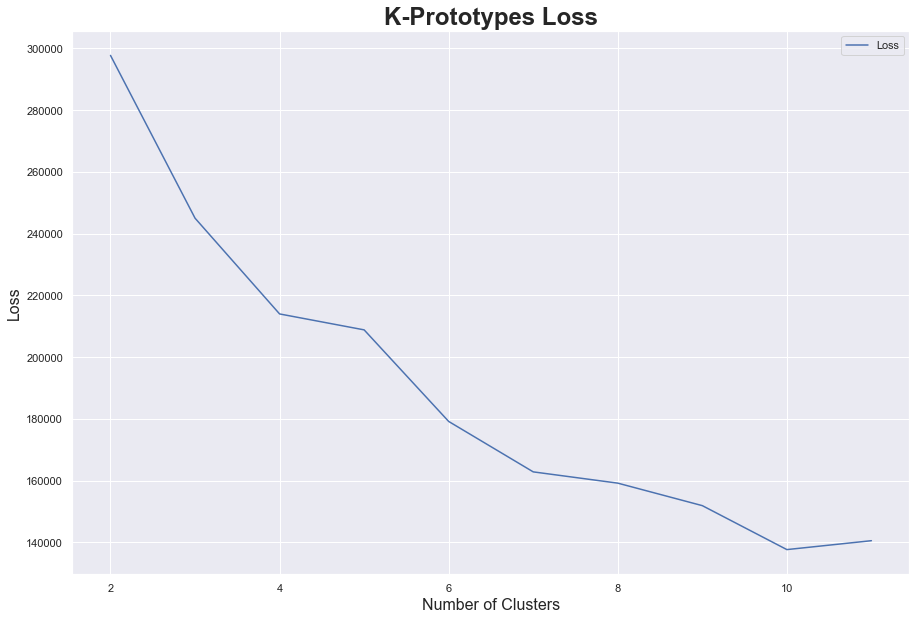

In [72]:
plt.figure(figsize=(15,10))

sns.lineplot(x=range(2,12), y=kp_loss, label='Loss')

plt.title(r'K-Prototypes Loss', fontsize=24, fontweight='bold')
plt.xlabel(r'Number of Clusters', fontsize=16)
plt.ylabel(f'Loss', fontsize=16)
plt.grid()
#plt.xlim([2,12])


plt.grid()
#plt.savefig('.',bbox_inches='tight', pad_inches=0)

Plot Bayesian and Akaike information criterions of GMM as a function of number of clusters

In [65]:
gmm_aic = []
gmm_bic = []

n_iters = 10
for n_clusters in tqdm(range(2, 12)):
    
    aic = 0
    bic = 0
    for _ in tqdm(range(n_iters), leave=False):
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', n_init=1, max_iter=100)
        gmm.fit(clustering_data)
        aic += gmm.aic(clustering_data)
        bic += gmm.bic(clustering_data)
        
    gmm_aic.append(aic/n_iters)
    gmm_bic.append(bic/n_iters)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
np.savez('cluster_loss.npz', gmm_aic=gmm_aic, gmm_bic=gmm_bic, kp_loss=kp_loss)

In [14]:
sns.set_theme(style="darkgrid")

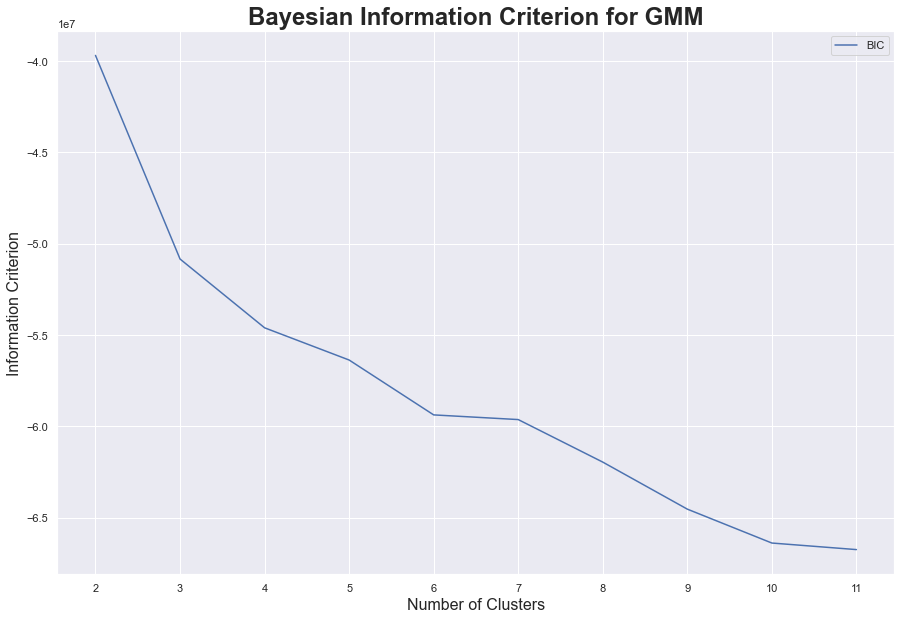

In [67]:
plt.figure(figsize=(15,10))

#sns.lineplot(x=range(2,12), y=gmm_aic, label='AIC')
sns.lineplot(x=range(2,12), y=gmm_bic, label='BIC')

#plt.title(r'Bayesian and Akaike Information Criterions', fontsize=24, fontweight='bold')
plt.title(r'Bayesian Information Criterion for GMM', fontsize=24, fontweight='bold')
plt.xlabel(r'Number of Clusters', fontsize=16)
plt.ylabel(f'Information Criterion', fontsize=16)
plt.grid()
plt.xticks(range(2,12))
#plt.xlim([0,12])

plt.grid()
#plt.savefig('.',bbox_inches='tight', pad_inches=0)

In [9]:
data = np.load('cluster_loss.npz')

In [10]:
loss, aic, bic = data['kp_loss'], data['gmm_aic'], data['gmm_bic']

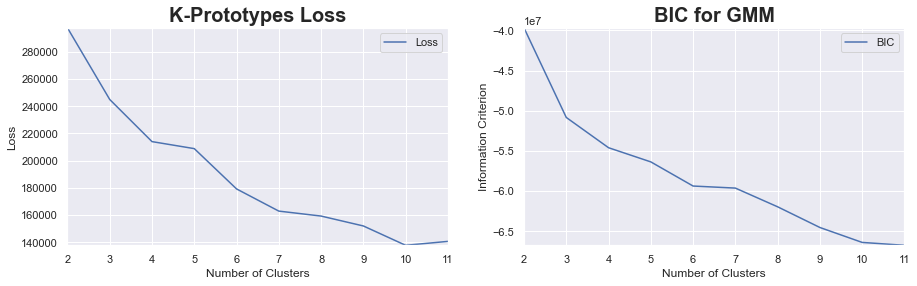

In [15]:
plt.figure(figsize=(15,4))

plt.subplot(121)
sns.lineplot(x=range(2,12), y=loss, label='Loss')
plt.title(r'K-Prototypes Loss', fontsize=20, fontweight='bold')
plt.xlabel(r'Number of Clusters', fontsize=12)
plt.ylabel(f'Loss', fontsize=12)
plt.grid()
plt.xticks(range(2,12))
plt.xlim([2,11])
plt.ylim([min(loss),max(loss)])
plt.grid()

plt.subplot(122)
#sns.lineplot(x=range(2,12), y=gmm_aic, label='AIC')
sns.lineplot(x=range(2,12), y=bic, label='BIC')
#plt.title(r'Bayesian and Akaike Information Criterions', fontsize=24, fontweight='bold')
plt.title(r'BIC for GMM', fontsize=20, fontweight='bold')
plt.xlabel(r'Number of Clusters', fontsize=12)
plt.ylabel(f'Information Criterion', fontsize=12)
plt.grid()
plt.xticks(range(2,12))
plt.xlim([2,11])
plt.ylim([min(bic),max(bic)])
plt.grid()

plt.savefig('cluster_loss.pdf',bbox_inches='tight', pad_inches=0)